<a href="https://colab.research.google.com/github/luizmv8080/aprendizaje-profundo/blob/main/Tarea1/Ejercicio_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2. Retropropagacion con red densa

La arquitectura de la red neuronal que se va a utilizar es la siguiente:

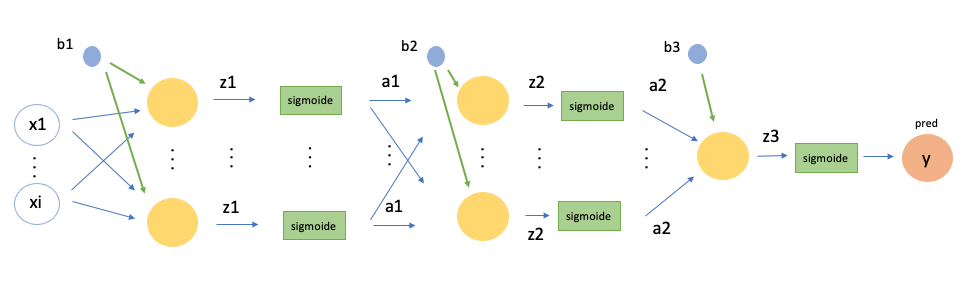

Tiene dos capas ocultas y cada neurona de cada capa se le asigna como funcion de activacion la funcion sigmoide.

In [2]:
import numpy as np
import seaborn as sns
import pandas as pd

Definimos la funcion de activacion que tendra cada neurona, en este caso sera una sigmoide

In [21]:
def funcionSigmoide(z):
  return 1/(1+np.exp(-z))

Definimos la derivada de la funcion de activacion, ya que sera necesaria para backpropagation

In [22]:
def derivadaSigmoide(z):
  return np.multiply(funcionSigmoide(z), (1.0 - funcionSigmoide(z)))

Definimos nuestra funcion de costo, en este caso, como sera una clasificacion binaria, se usara la funcion de entropia cruzada

In [23]:
def entropiaCruzada(y,y_predicha):
    y_predicha[y_predicha == 0] = np.nextafter(0., 1.)
    y_predicha[y_predicha == 1] = np.nextafter(1., 0.)
    return -(np.log(y_predicha[y == 1]).sum() + np.log(1 - y_predicha[y == 0]).sum())

Definimos la funcion que nos dara la exactitud de nuestra red neuronal, comparando los valores de nuestra prediccion "y_predicha" con los reales "y"

In [24]:
def funcionExactitud(y,y_predicha):
  return (y==y_predicha).mean()*100

In [25]:
def funcionScores(x,w1,w2,w3,b1,b2,b3):
  
  #Se multiplican las entradas x por los pesos w1 de las primeras neuronas de la primera capa oculta y luego se le suma el sesgo b1
  z1 = w1.T@x[:,np.newaxis] + b1
  #A cada salida de la neurona pasa por la funcion sigmoide y se obtiene el parametro a1
  a1 = funcionSigmoide(z1)

  #Ahora las entradas de la segunda capa oculta de neuronas son a1 y se repite el proceso de la primera capa
  z2 = w2.T@a1 + b2
  a2 = funcionSigmoide(z2)

  #Para la ultima capa (la cual ya no es capa oculta y esta formada por una sola neurona) se le pasan como entradas las salidas de la segunda capa oculta
  z3 = w3.T@a2 + b3
  #A la salida de esta neurona se le vuelve a aplicar la sigmoide y de esta froma se obtiene la prediccion del modelo
  pred = funcionSigmoide(z3)

  return z1,z2,z3,a1,a2,pred

In [26]:
def backPropagation(x,y,epocas,alpha,capa_oculta_1,capa_oculta_2):

  #Extraemos el numero de filas del dataset que sera estudiado
  n_ejemplos = x.shape[0]
  #Extraemos el numero de campos que contiene el dataset
  n_entradas = x.shape[1]

  #Inicializamos la matriz de pesos que van de la entrada a la primera capa oculta
  w1 = np.random.rand(n_entradas,capa_oculta_1)
  #Inicializamos el sesco para la primera capa oculta (inicializamos el vector con ceros)
  b1 = np.zeros((capa_oculta_1,1))

  #Inicializamos  la matriz de pesos que va de la primera capa oculta a la segunda capa oculta
  w2 = np.random.rand(capa_oculta_1,capa_oculta_2)
  #Inicializamos el sesgo para la segunda capa oculta (inicializamos el vector con ceros)
  b2 = np.zeros((capa_oculta_2,1))

  #Inicializamos  la matriz de pesos que van de la segunda capa oculta a la ultima neurona (la cual no se considera capa oculta)
  w3 = np.random.rand(capa_oculta_2,1)
  #Inicializamos el sesgo para la ultima neurona que sera activada
  b3 = np.zeros((1,1))

  exactitud = np.zeros((epocas))
  costo = np.zeros((epocas))
  y_predicha = np.zeros((y.shape))

  for i in range(epocas):
    for j in range(n_ejemplos):

      #Obtenemos los scores para cada fila del dataset que va entrando a la red neuronal
      z1,z2,z3,a1,a2,pred = funcionScores(x[j],w1,w2,w3,b1,b2,b3)

      #Se comienza el backpropagation y se obtiene la derivada de la funcion de perdida (L) respecto z3 (dz3)
      dz3 = pred - y[j]
      #La derivada de la funcion de perdida respecto w3 esta dada por: dL/dw3 = (dL/dz3)*(dz3/dw3) = (pred - y[j])*(a2)
      dw3 = np.outer(a2,dz3)
      #La derivada de la funcion de perdida respecto b3 esta dada por: dL/db3 = (dL/dz3)*(dz3/db3) = (pred - y[j])*(1)
      db3 = dz3
      
      #Ahora se obtiene la derivada de la funcion de perdida respecto a z2, por regla de la cadena se tiene: dL/dz2 = (dL/dz3)*(dz3/dz2) = (pred - y[j])*w3*(da2/dz2)
      dz2 = np.dot(w3,dz3)*derivadaSigmoide(z2)
      #La derivada de la funcion de perdida respecto w2 esta dada por: dL/dw2 = (dL/dz2)*(dz2/dw2) = [(pred - y[j])*w3*(da2/dz2)]*(a1)
      dw2 = np.outer(a1,dz2)
      #La derivada de la funcion de perdida respecto b2 esta dada por: dL/db2 = (dL/dz2)*(dz2/db2) = [(pred - y[j])*w3*(da2/dz2)]*(1)
      db2 = dz2

      #Ahora se obtiene la derivada de la funcion de perdida respecto a z1, por regla de la cadena se tiene: dL/dz1 = (dL/dz2)*(dz2/dz1) = [(pred - y[j])*w3*(da2/dz2)]*w2*(da1/dz1)
      dz1 = (w2@dz2)*derivadaSigmoide(z1)
      #La derivada de la funcion de perdida respecto w1 esta dada por: dL/dw1 = (dL/dz1)*(dz1/dw1) = {[(pred - y[j])*w3*(da2/dz2)]*w2*(da1/dz1)}*x
      dw1 = np.outer(x[j],dz1)
      #La derivada de la funcion de perdida respecto b1 esta dada por: dL/db2 = (dL/dz1)*(dz1/db1) = [(pred - y[j])*w3*(da2/dz2)]*w2*(da1/dz1)
      db1 = dz1

      #Ya teniendo conocimiento de como es que la funcion de perdida cambia respecto a cada parametro, podemos actualizar los parametros al mismo tiempo:
      w1 = w1 - alpha*dw1
      b1 = b1 - alpha*db1

      dw2 = w2 - alpha*dw2
      b2 = b2 - alpha*db2

      w3 = w3 - alpha*dw3
      b3 = b3 - alpha*db3

      y_predicha[j] = pred

    exactitud[i] = funcionExactitud(y,np.round(y_predicha))
    costo[i] = entropiaCruzada(y,y_predicha)
    print("Epoca: {0}, Costo: {1}, Exactitud: {2}".format(i,costo[i], exactitud[i]))
  return w1,w2,w3,b1,b2,b3,exactitud,costo

### Preparando el dataset Titanic
Usaremos el dataset de Titanic que nos proporciona seaborn:

In [27]:
data = sns.load_dataset("titanic")
data.head(2)

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False


Ahora llenamos los nulos y nos deshacemos de los valores nulos del dataset para que no estorben:

In [28]:
# Limpiar la columna Age
age = data['age'].fillna(data['age'].mean())
data['age'] = age

# Liampiar la columna Embark
data.dropna(inplace=True)

Nos aseguramos que no hayan quedado valores nulos:

In [29]:
data.isnull().sum()

survived       0
pclass         0
sex            0
age            0
sibsp          0
parch          0
fare           0
embarked       0
class          0
who            0
adult_male     0
deck           0
embark_town    0
alive          0
alone          0
dtype: int64

Ahora convertimos en valores dummies las variables que no tienen valores numericos, como 'sex', 'class', etc:

In [30]:
data_dummies = pd.get_dummies(data, columns=["sex","embarked","class","adult_male",'embark_town','who','adult_male', 'deck',
       'alive', 'alone'], prefix = "dummie")

Separamos en las variables independientes "data_x" y la variable dependiente "data_y" la cual contiene el valor de "dummie_yes" que es 1 si se encontro viva o 0 si no se encontro muerta la persona:

In [31]:
data_x = data_dummies[['survived', 'pclass', 'age', 'sibsp', 'parch', 'fare',  'dummie_A', 'dummie_B', 'dummie_C',
       'dummie_D', 'dummie_E', 'dummie_F',
       'dummie_female', 'dummie_C', 'dummie_Q',
       'dummie_First', 'dummie_Second',
       'dummie_True', 'dummie_Cherbourg', 'dummie_Queenstown', 'dummie_child', 'dummie_man','dummie_True', 'dummie_True']]

data_y = data_dummies['dummie_yes']

In [32]:
data_x.head(2)

,survived,pclass,age,sibsp,parch,fare,dummie_A,dummie_B,dummie_C,dummie_C,...,dummie_Cherbourg,dummie_Queenstown,dummie_child,dummie_man,dummie_True,dummie_True,dummie_True,dummie_True,dummie_True,dummie_True
1,1,1,38.0,1,0,71.2833,0,0,1,1,...,1,0,0,0,0,0,0,0,0,0
3,1,1,35.0,1,0,53.1000,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


Vemos que ya todos nuestros campos son numericos, sin embargo, vamos a normalizar la variable 'age' y 'fare' ya que sus valores son muy grandes a comparacion de los otros. De esta forma, nos aseguramos que los valores se encuentren entre la misma magnitud:

In [33]:
data_x['fare'] = data_x['fare']/max(data_x['fare'])
data_x['age'] = data_x['age']/max(data_x['age'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Ahora si convertimos nuestros dataset en arreglos de numpy para poder meterlos en la red neuronal:

In [34]:
x = data_x.to_numpy()
y = data_y.to_numpy().T

### Probando la red neuronal

In [35]:
w1,w2,w3,b1,b2,b3,exactitud,costo = backPropagation(x,y,400,0.1,10,3)

Epoca: 0, Costo: 132.69085909159654, Exactitud: 64.17910447761194
Epoca: 1, Costo: 132.18299281576822, Exactitud: 65.67164179104478
Epoca: 2, Costo: 132.18286123753495, Exactitud: 65.67164179104478
Epoca: 3, Costo: 132.1827289389881, Exactitud: 65.67164179104478
Epoca: 4, Costo: 132.18259590232796, Exactitud: 65.67164179104478
Epoca: 5, Costo: 132.18246211867853, Exactitud: 65.67164179104478
Epoca: 6, Costo: 132.18232757903883, Exactitud: 65.67164179104478
Epoca: 7, Costo: 132.18219227428062, Exactitud: 65.67164179104478
Epoca: 8, Costo: 132.18205619514583, Exactitud: 65.67164179104478
Epoca: 9, Costo: 132.18191933224404, Exactitud: 65.67164179104478
Epoca: 10, Costo: 132.18178167604998, Exactitud: 65.67164179104478
Epoca: 11, Costo: 132.18164321690088, Exactitud: 65.67164179104478
Epoca: 12, Costo: 132.18150394499375, Exactitud: 65.67164179104478
Epoca: 13, Costo: 132.1813638503827, Exactitud: 65.67164179104478
Epoca: 14, Costo: 132.1812229229761, Exactitud: 65.67164179104478
Epoca: 1

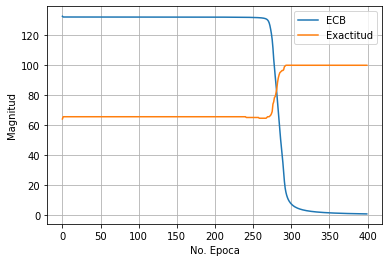

In [38]:
import matplotlib.pyplot as plt
plt.plot(np.arange(costo.size), costo, label='ECB')
plt.plot(np.arange(exactitud.size), exactitud, label='Exactitud')
plt.legend()
plt.xlabel('No. Epoca')
plt.ylabel('Magnitud')
plt.grid(True)
plt.show()

Vemos como la perdida decrece drasticamente a partir de la epoca 270 y la exactitud llega a su maximo un poco antes de llegar a la epoca 300